<a href="https://colab.research.google.com/github/owenwntr/metro_mayors_2021/blob/main/practice-baseline-model/Practice_Baseline_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import pandas as pd
import joblib
import numpy as np
import torch
import random
import albumentations
import matplotlib.pyplot as plt
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from PIL import Image
from tqdm import tqdm
from torchvision import models as models
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [2]:
images = pd.read_csv("/content/drive/MyDrive/Masters Thesis/images.csv")

images.head()

,Unnamed: 0,name,coordinates,timestamp,longlat,long,lat
0,0,1_4.89977506096613_52.3731063693188_46.8109420...,"[4.89977506096613, 52.3731063693188, 46.810942...",2020-04-21T10:06:30.849920Z,"(4.89977506096613, 52.3731063693188)",4.899775,52.373106
1,1,2_4.89984094530761_52.3730867069638_46.8488892...,"[4.89984094530761, 52.3730867069638, 46.848889...",2020-04-21T10:06:30.109930Z,"(4.89984094530761, 52.3730867069638)",4.899841,52.373087
2,2,3_4.89970843879619_52.3731249112232_46.7609646...,"[4.89970843879619, 52.3731249112232, 46.760964...",2020-04-21T10:06:31.599900Z,"(4.89970843879619, 52.3731249112232)",4.899708,52.373125
3,3,4_4.89990761833727_52.3730674802496_46.8995293...,"[4.89990761833727, 52.3730674802496, 46.899529...",2020-04-21T10:06:29.329940Z,"(4.89990761833727, 52.3730674802496)",4.899908,52.373067
4,4,5_4.89964054634617_52.3731419740492_46.7192306...,"[4.89964054634617, 52.3731419740492, 46.719230...",2020-04-21T10:06:32.374890Z,"(4.89964054634617, 52.3731419740492)",4.899641,52.373142


In [3]:
images['label'] = 2

In [4]:
images['label'] = np.where(images['long'] < 4.87, 0, images['label'])

In [5]:
images['label'] = np.where(images['lat'] > 52.375, 1, images['label'])

In [6]:
images['image_path'] = "/content/drive/MyDrive/Pano_Cityscapes_high_res/test_pano/" + images['name'] + ".jpg"

In [7]:
X = images.image_path.values
y = images.label.values

In [8]:
labels = np.array(images['label'])
# one hot encode
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# pickle the label binarizer
joblib.dump(lb, '/content/drive/MyDrive/UvA/Masters thesis/lb.pkl')
print('Save the one-hot encoded binarized labels as a pickled file.')

Save the one-hot encoded binarized labels as a pickled file.


In [9]:
(xtrain, xtest, ytrain, ytest) = (train_test_split(X, y, 
                                test_size=0.20, random_state=42))

In [15]:
# image dataset module
class pano_images(Dataset):
    def __init__(self, path, labels, tfms=None):
        self.X = path
        self.y = labels
        # apply augmentations
        if tfms == 0: # if validating
            self.aug = albumentations.Compose([
                albumentations.Resize(200, 400, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
        else: # if training
            self.aug = albumentations.Compose([
                albumentations.Resize(200, 400, always_apply=True),
                albumentations.HorizontalFlip(p=1.0),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        label = self.y[i]
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

In [16]:
train_data = pano_images(xtrain, ytrain, tfms=1)
test_data = pano_images(xtest, ytest, tfms=0)
 
# dataloaders
trainloader = DataLoader(train_data, batch_size=32, shuffle=True)
testloader = DataLoader(test_data, batch_size=32, shuffle=False)

(<matplotlib.axes._subplots.AxesSubplot at 0x7ff7a10e8510>,
 <matplotlib.image.AxesImage at 0x7ff7a103ea90>)

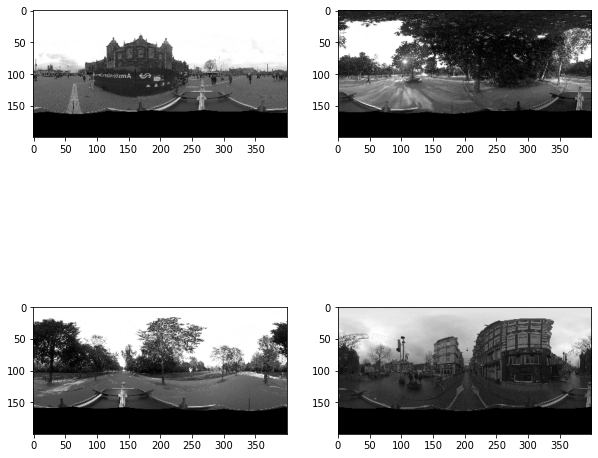

In [17]:
# visualizing images
i = 0
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_data[i][0][2], cmap='gray')
plt.subplot(222), plt.imshow(train_data[i+25][0][2], cmap='gray')
plt.subplot(223), plt.imshow(train_data[i+50][0][2], cmap='gray')
plt.subplot(224), plt.imshow(train_data[i+75][0][2], cmap='gray')

In [26]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer (output 320,000)
            Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer (output 80,000)
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer (output 20,000)
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer (output 1,250)
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(1200, 3)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        print(x.shape)
        x = x.view(x.size(0), -1)
        print(x.shape)
        x = self.linear_layers(x)
        return x

In [27]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_run

In [28]:
''' SEED Everything '''
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True 
SEED=42
seed_everything(SEED=SEED)
''' SEED Everything '''
# set computation device
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")

Computation device: cuda:0


In [21]:
# construct the argument parser and parse the arguments
parser = argparse.ArgumentParser()
parser.add_argument('-e', '--epochs', default=10, type=int,
    help='number of epochs to train the model for')
args = vars(parser.parse_args())

usage: ipykernel_launcher.py [-h] [-e EPOCHS]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-1c8527b4-b78c-44f3-aee1-f496fdeb6132.json


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [29]:
# load label binarizer
lb = joblib.load('/content/drive/MyDrive/UvA/Masters thesis/lb.pkl')

In [30]:
#validation function
def validate(model, test_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader), total=int(len(test_data)/test_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss/len(test_dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy

In [31]:
# training function
def fit(model, train_dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_data)/train_dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy

In [32]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
epochs = 30
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print(f"{(end-start)/60:.3f} minutes")


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1 of 30
Training
torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 33%|███▎      | 2/6 [00:35<00:53, 13.35s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 50%|█████     | 3/6 [01:06<00:55, 18.41s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 67%|██████▋   | 4/6 [01:33<00:42, 21.19s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 83%|████████▎ | 5/6 [02:00<00:22, 22.94s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



100%|██████████| 6/6 [02:28<00:00, 24.35s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



7it [02:35, 22.21s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([8, 4, 12, 25])
torch.Size([8, 1200])
Train Loss: 0.5029, Train Acc: 43.00
Validating



100%|██████████| 1/1 [00:24<00:00, 24.86s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



2it [00:39, 19.98s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([18, 4, 12, 25])
torch.Size([18, 1200])
Val Loss: 1.6319, Val Acc: 50.00
Epoch 2 of 30
Training



 17%|█▋        | 1/6 [00:05<00:29,  5.95s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 33%|███▎      | 2/6 [00:11<00:23,  5.97s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 50%|█████     | 3/6 [00:18<00:18,  6.02s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 67%|██████▋   | 4/6 [00:24<00:12,  6.02s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 83%|████████▎ | 5/6 [00:30<00:06,  6.01s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



100%|██████████| 6/6 [00:36<00:00,  6.03s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



7it [00:37,  5.39s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([8, 4, 12, 25])
torch.Size([8, 1200])
Train Loss: 0.0556, Train Acc: 60.50
Validating



100%|██████████| 1/1 [00:06<00:00,  6.05s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



2it [00:09,  4.73s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([18, 4, 12, 25])
torch.Size([18, 1200])
Val Loss: 0.9794, Val Acc: 44.00
Epoch 3 of 30
Training



 17%|█▋        | 1/6 [00:06<00:30,  6.14s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 33%|███▎      | 2/6 [00:12<00:24,  6.12s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 50%|█████     | 3/6 [00:18<00:18,  6.11s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 67%|██████▋   | 4/6 [00:24<00:12,  6.07s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 83%|████████▎ | 5/6 [00:30<00:06,  6.05s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



100%|██████████| 6/6 [00:36<00:00,  6.08s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



7it [00:37,  5.43s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([8, 4, 12, 25])
torch.Size([8, 1200])
Train Loss: 0.0223, Train Acc: 75.50
Validating



100%|██████████| 1/1 [00:06<00:00,  6.00s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



2it [00:09,  4.71s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([18, 4, 12, 25])
torch.Size([18, 1200])
Val Loss: 0.1875, Val Acc: 54.00
Epoch 4 of 30
Training



 17%|█▋        | 1/6 [00:06<00:30,  6.09s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 33%|███▎      | 2/6 [00:12<00:24,  6.12s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 50%|█████     | 3/6 [00:18<00:18,  6.11s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 67%|██████▋   | 4/6 [00:24<00:12,  6.13s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 83%|████████▎ | 5/6 [00:30<00:06,  6.13s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



100%|██████████| 6/6 [00:36<00:00,  6.12s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



7it [00:38,  5.47s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([8, 4, 12, 25])
torch.Size([8, 1200])
Train Loss: 0.0215, Train Acc: 74.00
Validating



100%|██████████| 1/1 [00:06<00:00,  6.11s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



2it [00:09,  4.80s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([18, 4, 12, 25])
torch.Size([18, 1200])
Val Loss: 0.1195, Val Acc: 54.00
Epoch 5 of 30
Training



 17%|█▋        | 1/6 [00:06<00:30,  6.06s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 33%|███▎      | 2/6 [00:12<00:24,  6.07s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 50%|█████     | 3/6 [00:18<00:18,  6.06s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 67%|██████▋   | 4/6 [00:24<00:12,  6.06s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 83%|████████▎ | 5/6 [00:30<00:06,  6.11s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



100%|██████████| 6/6 [00:36<00:00,  6.14s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



7it [00:38,  5.47s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([8, 4, 12, 25])
torch.Size([8, 1200])
Train Loss: 0.0138, Train Acc: 84.00
Validating



100%|██████████| 1/1 [00:06<00:00,  6.09s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



2it [00:09,  4.78s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([18, 4, 12, 25])
torch.Size([18, 1200])
Val Loss: 0.0641, Val Acc: 56.00
Epoch 6 of 30
Training



 17%|█▋        | 1/6 [00:06<00:30,  6.16s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 33%|███▎      | 2/6 [00:12<00:24,  6.18s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 50%|█████     | 3/6 [00:18<00:18,  6.14s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 67%|██████▋   | 4/6 [00:24<00:12,  6.11s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 83%|████████▎ | 5/6 [00:30<00:06,  6.12s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



100%|██████████| 6/6 [00:36<00:00,  6.07s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



7it [00:38,  5.44s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([8, 4, 12, 25])
torch.Size([8, 1200])
Train Loss: 0.0106, Train Acc: 88.50
Validating



100%|██████████| 1/1 [00:05<00:00,  5.99s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



2it [00:09,  4.68s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([18, 4, 12, 25])
torch.Size([18, 1200])
Val Loss: 0.0363, Val Acc: 68.00
Epoch 7 of 30
Training



 17%|█▋        | 1/6 [00:06<00:30,  6.04s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 33%|███▎      | 2/6 [00:12<00:24,  6.03s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 50%|█████     | 3/6 [00:18<00:18,  6.06s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 67%|██████▋   | 4/6 [00:24<00:12,  6.11s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 83%|████████▎ | 5/6 [00:30<00:06,  6.11s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



100%|██████████| 6/6 [00:36<00:00,  6.06s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



7it [00:37,  5.42s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([8, 4, 12, 25])
torch.Size([8, 1200])
Train Loss: 0.0083, Train Acc: 91.50
Validating



100%|██████████| 1/1 [00:06<00:00,  6.08s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



2it [00:09,  4.75s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([18, 4, 12, 25])
torch.Size([18, 1200])
Val Loss: 0.0410, Val Acc: 74.00
Epoch 8 of 30
Training



 17%|█▋        | 1/6 [00:05<00:29,  5.95s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 33%|███▎      | 2/6 [00:12<00:24,  6.01s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 50%|█████     | 3/6 [00:18<00:18,  6.02s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 67%|██████▋   | 4/6 [00:24<00:12,  6.06s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 83%|████████▎ | 5/6 [00:30<00:06,  6.06s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



100%|██████████| 6/6 [00:36<00:00,  6.09s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



7it [00:38,  5.45s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([8, 4, 12, 25])
torch.Size([8, 1200])
Train Loss: 0.0053, Train Acc: 95.50
Validating



100%|██████████| 1/1 [00:06<00:00,  6.02s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



2it [00:09,  4.71s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([18, 4, 12, 25])
torch.Size([18, 1200])
Val Loss: 0.0640, Val Acc: 68.00
Epoch 9 of 30
Training



 17%|█▋        | 1/6 [00:05<00:29,  5.96s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 33%|███▎      | 2/6 [00:11<00:23,  5.98s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 50%|█████     | 3/6 [00:18<00:18,  6.04s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 67%|██████▋   | 4/6 [00:24<00:12,  6.02s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 83%|████████▎ | 5/6 [00:30<00:06,  6.04s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



100%|██████████| 6/6 [00:36<00:00,  6.04s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



7it [00:37,  5.40s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([8, 4, 12, 25])
torch.Size([8, 1200])
Train Loss: 0.0030, Train Acc: 96.00
Validating



100%|██████████| 1/1 [00:05<00:00,  6.00s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



2it [00:09,  4.70s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([18, 4, 12, 25])
torch.Size([18, 1200])
Val Loss: 0.0460, Val Acc: 74.00
Epoch 10 of 30
Training



 17%|█▋        | 1/6 [00:06<00:30,  6.11s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 33%|███▎      | 2/6 [00:12<00:24,  6.10s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 50%|█████     | 3/6 [00:18<00:18,  6.06s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 67%|██████▋   | 4/6 [00:24<00:12,  6.05s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 83%|████████▎ | 5/6 [00:30<00:06,  6.05s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



100%|██████████| 6/6 [00:36<00:00,  6.06s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



7it [00:37,  5.41s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([8, 4, 12, 25])
torch.Size([8, 1200])
Train Loss: 0.0020, Train Acc: 98.50
Validating



100%|██████████| 1/1 [00:06<00:00,  6.03s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



2it [00:09,  4.74s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([18, 4, 12, 25])
torch.Size([18, 1200])
Val Loss: 0.0462, Val Acc: 74.00
Epoch 11 of 30
Training



 17%|█▋        | 1/6 [00:06<00:30,  6.11s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 33%|███▎      | 2/6 [00:12<00:24,  6.12s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 50%|█████     | 3/6 [00:18<00:18,  6.13s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 67%|██████▋   | 4/6 [00:24<00:12,  6.12s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 83%|████████▎ | 5/6 [00:30<00:06,  6.13s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



100%|██████████| 6/6 [00:36<00:00,  6.11s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



7it [00:38,  5.47s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([8, 4, 12, 25])
torch.Size([8, 1200])
Train Loss: 0.0021, Train Acc: 99.00
Validating



100%|██████████| 1/1 [00:05<00:00,  5.96s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



2it [00:09,  4.69s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([18, 4, 12, 25])
torch.Size([18, 1200])
Val Loss: 0.0539, Val Acc: 74.00
Epoch 12 of 30
Training



 17%|█▋        | 1/6 [00:06<00:30,  6.16s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 33%|███▎      | 2/6 [00:12<00:24,  6.13s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 50%|█████     | 3/6 [00:18<00:18,  6.11s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 67%|██████▋   | 4/6 [00:24<00:12,  6.07s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 83%|████████▎ | 5/6 [00:30<00:06,  6.06s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



100%|██████████| 6/6 [00:36<00:00,  6.04s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



7it [00:37,  5.40s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([8, 4, 12, 25])
torch.Size([8, 1200])
Train Loss: 0.0013, Train Acc: 98.50
Validating



100%|██████████| 1/1 [00:06<00:00,  6.07s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



2it [00:09,  4.74s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([18, 4, 12, 25])
torch.Size([18, 1200])
Val Loss: 0.0487, Val Acc: 80.00
Epoch 13 of 30
Training



 17%|█▋        | 1/6 [00:06<00:30,  6.06s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 33%|███▎      | 2/6 [00:12<00:24,  6.08s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 50%|█████     | 3/6 [00:18<00:18,  6.07s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 67%|██████▋   | 4/6 [00:24<00:12,  6.06s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 83%|████████▎ | 5/6 [00:30<00:06,  6.05s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



100%|██████████| 6/6 [00:36<00:00,  6.03s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



7it [00:37,  5.41s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([8, 4, 12, 25])
torch.Size([8, 1200])
Train Loss: 0.0004, Train Acc: 100.00
Validating



100%|██████████| 1/1 [00:06<00:00,  6.02s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



2it [00:09,  4.71s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([18, 4, 12, 25])
torch.Size([18, 1200])
Val Loss: 0.0458, Val Acc: 76.00
Epoch 14 of 30
Training



 17%|█▋        | 1/6 [00:06<00:30,  6.02s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 33%|███▎      | 2/6 [00:12<00:24,  6.05s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 50%|█████     | 3/6 [00:18<00:18,  6.05s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 67%|██████▋   | 4/6 [00:24<00:12,  6.03s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 83%|████████▎ | 5/6 [00:30<00:06,  6.03s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



100%|██████████| 6/6 [00:36<00:00,  6.00s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



7it [00:37,  5.39s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([8, 4, 12, 25])
torch.Size([8, 1200])
Train Loss: 0.0040, Train Acc: 98.50
Validating



100%|██████████| 1/1 [00:05<00:00,  5.97s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



2it [00:09,  4.69s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([18, 4, 12, 25])
torch.Size([18, 1200])
Val Loss: 0.0595, Val Acc: 64.00
Epoch 15 of 30
Training



 17%|█▋        | 1/6 [00:05<00:29,  5.91s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 33%|███▎      | 2/6 [00:11<00:23,  5.95s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 50%|█████     | 3/6 [00:17<00:17,  5.97s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 67%|██████▋   | 4/6 [00:23<00:11,  5.99s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 83%|████████▎ | 5/6 [00:30<00:06,  6.00s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



100%|██████████| 6/6 [00:36<00:00,  6.01s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



7it [00:37,  5.37s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([8, 4, 12, 25])
torch.Size([8, 1200])
Train Loss: 0.0183, Train Acc: 85.00
Validating



100%|██████████| 1/1 [00:06<00:00,  6.04s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



2it [00:09,  4.72s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([18, 4, 12, 25])
torch.Size([18, 1200])
Val Loss: 0.2729, Val Acc: 54.00
Epoch 16 of 30
Training



 17%|█▋        | 1/6 [00:06<00:30,  6.07s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 33%|███▎      | 2/6 [00:12<00:24,  6.07s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 50%|█████     | 3/6 [00:18<00:18,  6.07s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 67%|██████▋   | 4/6 [00:24<00:12,  6.08s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 83%|████████▎ | 5/6 [00:30<00:06,  6.09s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



100%|██████████| 6/6 [00:36<00:00,  6.09s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



7it [00:38,  5.44s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([8, 4, 12, 25])
torch.Size([8, 1200])
Train Loss: 0.0147, Train Acc: 86.00
Validating



100%|██████████| 1/1 [00:06<00:00,  6.14s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



2it [00:09,  4.84s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([18, 4, 12, 25])
torch.Size([18, 1200])
Val Loss: 0.0925, Val Acc: 70.00
Epoch 17 of 30
Training



 17%|█▋        | 1/6 [00:05<00:29,  5.97s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 33%|███▎      | 2/6 [00:12<00:24,  6.03s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 50%|█████     | 3/6 [00:18<00:18,  6.07s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 67%|██████▋   | 4/6 [00:24<00:12,  6.05s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 83%|████████▎ | 5/6 [00:30<00:06,  6.09s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



100%|██████████| 6/6 [00:36<00:00,  6.09s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



7it [00:38,  5.45s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([8, 4, 12, 25])
torch.Size([8, 1200])
Train Loss: 0.0079, Train Acc: 90.00
Validating



100%|██████████| 1/1 [00:06<00:00,  6.12s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



2it [00:09,  4.78s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([18, 4, 12, 25])
torch.Size([18, 1200])
Val Loss: 0.0568, Val Acc: 72.00
Epoch 18 of 30
Training



 17%|█▋        | 1/6 [00:06<00:30,  6.16s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 33%|███▎      | 2/6 [00:12<00:24,  6.18s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 50%|█████     | 3/6 [00:18<00:18,  6.17s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 67%|██████▋   | 4/6 [00:24<00:12,  6.17s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 83%|████████▎ | 5/6 [00:30<00:06,  6.17s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



100%|██████████| 6/6 [00:37<00:00,  6.20s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



7it [00:38,  5.52s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([8, 4, 12, 25])
torch.Size([8, 1200])
Train Loss: 0.0044, Train Acc: 96.00
Validating



100%|██████████| 1/1 [00:06<00:00,  6.15s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



2it [00:09,  4.82s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([18, 4, 12, 25])
torch.Size([18, 1200])
Val Loss: 0.0492, Val Acc: 66.00
Epoch 19 of 30
Training



 17%|█▋        | 1/6 [00:06<00:31,  6.22s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 33%|███▎      | 2/6 [00:12<00:24,  6.19s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 50%|█████     | 3/6 [00:18<00:18,  6.17s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 67%|██████▋   | 4/6 [00:24<00:12,  6.17s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 83%|████████▎ | 5/6 [00:30<00:06,  6.17s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



100%|██████████| 6/6 [00:37<00:00,  6.18s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



7it [00:38,  5.51s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([8, 4, 12, 25])
torch.Size([8, 1200])
Train Loss: 0.0026, Train Acc: 99.00
Validating



100%|██████████| 1/1 [00:06<00:00,  6.04s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



2it [00:09,  4.73s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([18, 4, 12, 25])
torch.Size([18, 1200])
Val Loss: 0.0544, Val Acc: 72.00
Epoch 20 of 30
Training



 17%|█▋        | 1/6 [00:06<00:30,  6.04s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 33%|███▎      | 2/6 [00:12<00:24,  6.05s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 50%|█████     | 3/6 [00:18<00:18,  6.03s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 67%|██████▋   | 4/6 [00:24<00:12,  6.05s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 83%|████████▎ | 5/6 [00:30<00:06,  6.08s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



100%|██████████| 6/6 [00:36<00:00,  6.11s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



7it [00:38,  5.44s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([8, 4, 12, 25])
torch.Size([8, 1200])
Train Loss: 0.0017, Train Acc: 99.00
Validating



100%|██████████| 1/1 [00:06<00:00,  6.14s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



2it [00:09,  4.80s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([18, 4, 12, 25])
torch.Size([18, 1200])
Val Loss: 0.0557, Val Acc: 66.00
Epoch 21 of 30
Training



 17%|█▋        | 1/6 [00:06<00:30,  6.12s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 33%|███▎      | 2/6 [00:12<00:24,  6.13s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 50%|█████     | 3/6 [00:18<00:18,  6.10s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 67%|██████▋   | 4/6 [00:24<00:12,  6.11s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 83%|████████▎ | 5/6 [00:30<00:06,  6.09s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



100%|██████████| 6/6 [00:36<00:00,  6.09s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



7it [00:38,  5.45s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([8, 4, 12, 25])
torch.Size([8, 1200])
Train Loss: 0.0007, Train Acc: 100.00
Validating



100%|██████████| 1/1 [00:06<00:00,  6.07s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



2it [00:09,  4.76s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([18, 4, 12, 25])
torch.Size([18, 1200])
Val Loss: 0.0605, Val Acc: 66.00
Epoch 22 of 30
Training



 17%|█▋        | 1/6 [00:06<00:30,  6.13s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])



 33%|███▎      | 2/6 [00:12<00:24,  6.15s/it]

torch.Size([32, 4, 12, 25])
torch.Size([32, 1200])


IndexError: ignored

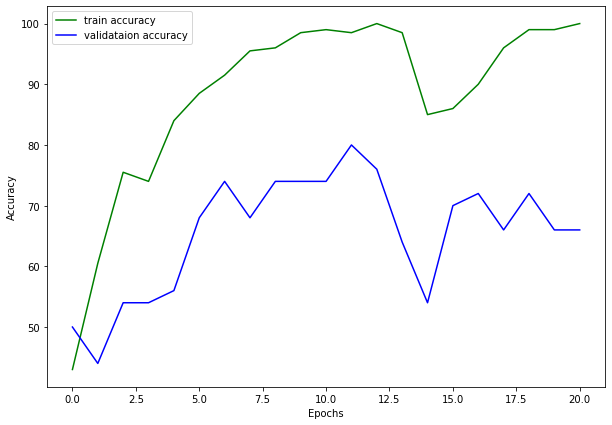

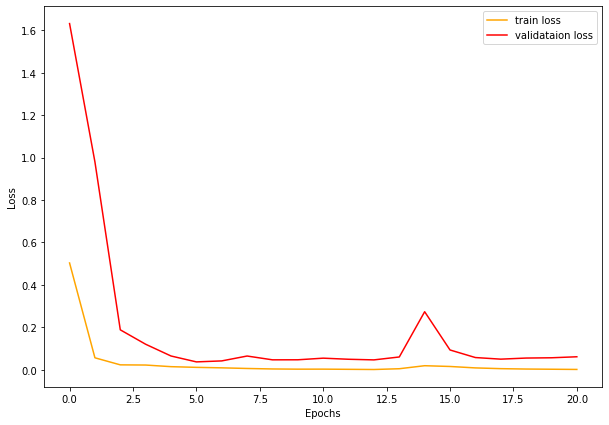

In [33]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('../outputs/accuracy.png')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('../outputs/loss.png')
plt.show()

In [ ]:
from lime import lime_image

In [ ]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=3, 
                                         hide_color=0, 
                                         num_samples=250) # number of images that will be sent to classification function